In [11]:
import os
import sys

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = "cuda"
    print("Cuda loaded.")
else:
    print("No cuda warning!")

import cvxpy as cp

Cuda loaded.


In [12]:
# Add the parent directory to sys.path
sys.path.append("..")

from utils import *

In [13]:
# Parameters

LR = 1e-2
NUM_ITER = 1000

# for synthesised (x, y) using PGD

TOL = 1e-8
MAX_ITER = 10 ** 4

In [14]:
# Load data

data_dir = "../data/"

x_train = torch.load(os.path.join(data_dir, 'x_train.pt')).to(device)
y_train = torch.load(os.path.join(data_dir, 'y_train.pt')).to(device)
x_test = torch.load(os.path.join(data_dir, 'x_test.pt')).to(device)
y_test = torch.load(os.path.join(data_dir, 'y_test.pt')).to(device)  # feasible for small moon data

# Cast to dataset

train_data = CastedDataset(x_train, y_train)
# test_dataset = CastedDataset(x_test, y_test)

In [15]:
# constraints

X0_MIN = torch.min(x_train[:, 0]).item()
X0_MAX = torch.max(x_train[:, 0]).item()

X1_MIN = torch.min(x_train[:, 1]).item()
X1_MAX = torch.max(x_train[:, 1]).item()

In [16]:
# Load wstar

FSTAR = LogisticRegression()
FSTAR.load_state_dict(torch.load(os.path.join(data_dir, 'wstar.pt')))

FSTAR.to(device)

WSTAR = torch.cat([param.data.flatten() for param in FSTAR.parameters()])  # for score computation

In [17]:
# Init student

student = LogisticRegression()
student.load_state_dict(torch.load(os.path.join(data_dir, 'w0.pt')))

student.to(device)

student_optimizer = torch.optim.SGD(
    student.parameters(),
    lr=LR
)

student_log = Log()

In [18]:
# Evaluate before training

def eval(student, log):

    student.eval()

    w_dist = torch.stack([torch.norm(p1 - p2) ** 2 for p1, p2 in zip(student.parameters(), FSTAR.parameters())]).sum().item()
    train_loss = nn.BCEWithLogitsLoss()(student(x_train), y_train).item()
    test_acc = (((student(x_test) > 0.5) == y_test).sum() / len(y_test)).item()

    log.w_dist.append(w_dist)
    log.train_loss.append(train_loss)
    log.test_acc.append(test_acc)


eval(student, student_log)

In [19]:
def train(num_iter, student, optimizer, log):

    loader = DataLoader(train_data, batch_size=1, shuffle=True)
    iter_loader = iter(loader)

    for i in (pbar := tqdm(range(num_iter))):

        # =============== teacher works ===============

        student.eval()

        # Get random sample
        try:
            x_old, y_old = next(iter_loader)
        except:
            iter_loader = iter(loader)
            x_old, y_old= next(iter_loader)

        # Synthesis x, y by PGD

        x = x_old.clone().detach().requires_grad_(True)
        y = y_old.clone().detach().requires_grad_(True)

        x_optimizer = torch.optim.Adam([x], lr=1)
        y_optimizer = torch.optim.Adam([y], lr=1)

        score_old = None
        
        for xy_iter in range(1, MAX_ITER + 1):  # should suffice

            x_optimizer.zero_grad()
            y_optimizer.zero_grad()

            loss = nn.BCEWithLogitsLoss()(student(x), y)

            grad = torch.autograd.grad(
                loss,
                student.parameters(),
                create_graph=True
            )
            
            grad = torch.cat([g.reshape(g.shape[0], -1) for g in grad], dim=1)

            T1 = torch.sum(grad ** 2, 1)
            
            w = torch.cat([param.data.flatten() for param in student.parameters()])
            T2 = grad @ (w - WSTAR).squeeze()

            score = LR**2 * T1 - 2 * LR * T2

            score.backward()
            
            x_optimizer.step()
            y_optimizer.step()

            # Uncomment to apply constraints
            # x.data[0][0] = torch.clamp(x.data[0][0], X0_MIN, X0_MAX)
            # x.data[0][1] = torch.clamp(x.data[0][1], X1_MIN, X1_MAX)
            # y.data = torch.clamp(y.data, 0, 1)

            if (score_old is not None) and (abs(score - score_old) < TOL):
                break
            else:
                score_old = score

        # =========================

        # Train student

        student.train()

        optimizer.zero_grad()
        loss = nn.BCEWithLogitsLoss()(student(x), y)
        loss.backward()
        optimizer.step()

        # Eval student
        student.eval()

        w_dist = torch.stack([torch.norm(p1 - p2) ** 2 for p1, p2 in zip(student.parameters(), FSTAR.parameters())]).sum().item()
        train_loss = nn.BCEWithLogitsLoss()(student(x_train), y_train).item()
        test_acc = (((student(x_test) > 0.5) == y_test).sum() / len(y_test)).item()

        # Update log
        log.iter += 1
        log.w_dist.append(w_dist)
        log.train_loss.append(train_loss)
        log.test_acc.append(test_acc)

        pbar.set_description(f"Iter {log.iter}, w_dist = {w_dist:.4f}, train loss = {train_loss:.4f}, test acc = {test_acc:.4f}")

In [20]:
train(NUM_ITER, student, student_optimizer, student_log)

Iter 1, w_dist = 0.1340, train loss = 0.2862, test acc = 0.8700:   0%|          | 1/1000 [00:00<09:49,  1.69it/s]

Iter 1000, w_dist = 0.0000, train loss = 0.2800, test acc = 0.8850: 100%|██████████| 1000/1000 [01:01<00:00, 16.15it/s]


Text(0, 0.5, 'Test Accuracy')

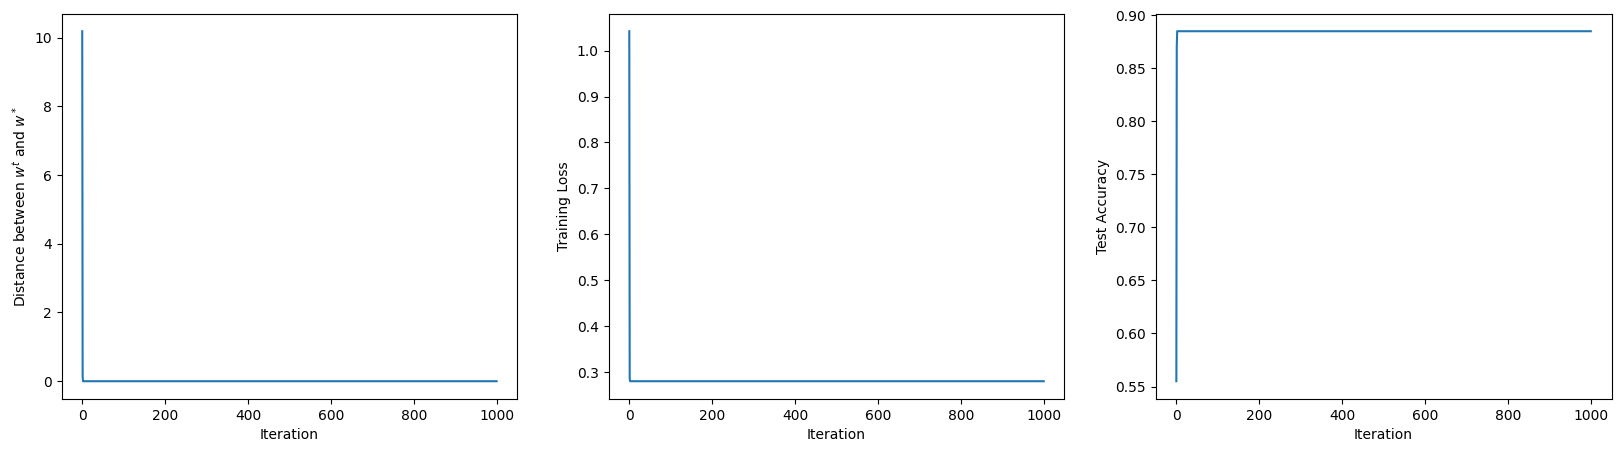

In [21]:
# Plot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(student_log.w_dist)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel(f"Distance between $w^t$ and $w^*$")

ax[1].plot(student_log.train_loss)
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Training Loss")

ax[2].plot(student_log.test_acc)
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Test Accuracy")

In [22]:
# Save results

results_dir = "../results/"

results = {
    "w": student_log.w_dist,
    "loss": student_log.train_loss,
    "acc": student_log.test_acc
}

np.save(os.path.join(results_dir, 'Joint.npy'), results)

# np.save(os.path.join(results_dir, 'Joint_xrange_soft.npy'), results)